#<b> Plant Seedling image classification <b>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/

Mounted at /content/drive/
/content/drive/My Drive


<b> Import Libraries <b>

In [2]:
import numpy as np
import pandas as pd
import os
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from random import randrange
import cv2



<b> Loading image filenames of training dataset with different classes(Seven classes) into dataframe <b>

In [14]:
path='/content/drive/My Drive/image/'
train_df=pd.DataFrame(columns=['filename','class'])
for root,dir,filenames in os.walk(path):
    for filename in filenames:
      path_name = os.path.join(root, filename)
      class_label = root.split('/')[-1]
      train_df= train_df.append({'filename':path_name , 'class':class_label}, ignore_index = True)

In [15]:
df=sklearn.utils.shuffle(train_df)
df.reset_index()
df.head(5)

,filename,class
2686,/content/drive/My Drive/image/silky_bent/477.png,silky_bent
280,/content/drive/My Drive/image/black_grass/90.png,black_grass
3596,/content/drive/My Drive/image/mayweed/288.png,mayweed
468,/content/drive/My Drive/image/Charlock/119.png,Charlock
774,/content/drive/My Drive/image/Cleavers/255.png,Cleavers


In [16]:
df.shape

(3781, 2)

<b> Loading image filenames of testing dataset with single classes into dataframe <b>

In [7]:
path_test='/content/drive/My Drive/test/'
test_df=pd.DataFrame(columns=['filename','class'])
for root,dir,filenames in os.walk(path_test):
    for filename in filenames:
      path_name = os.path.join(root, filename)
      class_label = root.split('/')[-1]
      test_df= test_df.append({'filename':path_name , 'class':class_label}, ignore_index = True)

In [ ]:
t_df=sklearn.utils.shuffle(test_df)
t_df.head(5)

,filename,class
32,/content/drive/My Drive/test/common_chickweed/...,common_chickweed
40,/content/drive/My Drive/test/common_chickweed/...,common_chickweed
9,/content/drive/My Drive/test/common_chickweed/...,common_chickweed
6,/content/drive/My Drive/test/common_chickweed/...,common_chickweed
42,/content/drive/My Drive/test/common_chickweed/...,common_chickweed


In [ ]:
t_df.shape

(50, 2)

<b>Loading All training data to an image generator<b>

In [17]:
classes={'Charlock': 0,
 'Cleavers': 1,
 'Fat_Hen': 2,
 'black_grass': 3,
 'common_chickweed': 4,
 'mayweed': 5,
 'silky_bent': 6}

image_size = 256
target_size = (256, 256)
batch_size = 32

# create a data generator
datagen = ImageDataGenerator()

<b> Vizualizing the images of different classes.<b>

In [18]:
from pandas.core.dtypes.common import classes
train_it = datagen.flow_from_directory('/content/drive/My Drive/image/', class_mode='categorical', batch_size=32,shuffle=True,seed=1,target_size=target_size,subset='training')                                         
test_it=datagen.flow_from_directory('/content/drive/My Drive/test/', class_mode='categorical', batch_size=32,shuffle=True,seed=1,target_size=target_size,subset='training')                                                    

Found 3781 images belonging to 7 classes.
Found 50 images belonging to 1 classes.


In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

def show_unique_grid(image_gen, figsize=(10,10)):
    dist_classes = [image_gen.classes.tolist().index(x) for x in set(image_gen.classes.tolist())]
    title_list = [image_gen.classes.tolist()[i] for i in dist_classes]
    im_set = [image_gen[i//32][0][i%32] for i in dist_classes]
    fig = plt.figure(None, (10,10),frameon=False)
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=(1, 7),  
                     axes_pad=0.2, 
                     share_all=True,
                     )
    for i in range(7):
        ax = grid[i]
        ax.imshow(im_set[i]/255)
        ax.set_title(title_list[i])
        ax.axis('off')

{'Charlock': 0,
 'Cleavers': 1,
 'Fat_Hen': 2,
 'black_grass': 3,
 'common_chickweed': 4,
 'mayweed': 5,
 'silky_bent': 6}

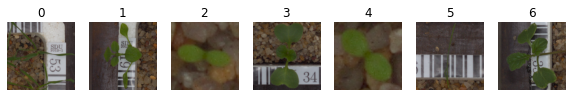

In [ ]:
show_unique_grid(train_it)
train_it.class_indices

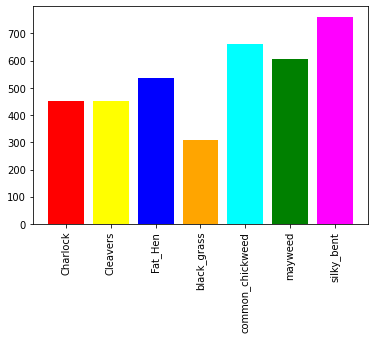

In [24]:
unique, counts = np.unique(train_it.classes, return_counts=True)
dict1 = dict(zip(train_it.class_indices, counts))

keys = dict1.keys()
values = dict1.values()
c = ['red', 'yellow', 'blue', 'orange','cyan','green','magenta']
plt.xticks(rotation='vertical')
bar = plt.bar(keys, values,color=c)

<b> Model Preparation <b>

In [ ]:
def get_model():
    model = tf.keras.models.Sequential() #1
    model.add(tf.keras.layers.InputLayer(input_shape=(image_size,image_size,3,))) #2
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')) #3
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')) #4
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #5
    model.add(tf.keras.layers.BatchNormalization()) #6
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu')) #7
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #8
    model.add(tf.keras.layers.BatchNormalization()) #9
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu')) #10
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #11
    model.add(tf.keras.layers.BatchNormalization()) #12
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu')) #13
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #14
    model.add(tf.keras.layers.GlobalMaxPool2D()) #15
    model.add(tf.keras.layers.Flatten()) #16 
    model.add(tf.keras.layers.Dense(128, activation='relu')) #17
    model.add(tf.keras.layers.Dropout(0.2)) #18
    model.add(tf.keras.layers.Dense(64, activation='relu')) #19
    model.add(tf.keras.layers.BatchNormalization()) #20
    model.add(tf.keras.layers.Dense(7, activation='softmax')) #21
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
get_model().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)      

In [ ]:
idg3 = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            horizontal_flip=True,
            vertical_flip=True,
            validation_split=0.2
           )
train_gen = idg3.flow_from_directory(path,
                                    target_size=target_size,
                                    subset='training',
                                    class_mode='categorical',
                                    batch_size=batch_size,
                                    shuffle=True,
                                    seed=1,
                                     classes=classes
                                     )
val_gen = idg3.flow_from_directory(path,
                                  target_size=(image_size, image_size),                                                   
                                  subset='validation',
                                  class_mode='categorical',
                                  batch_size=batch_size,
                                  shuffle=True,
                                  seed=1,
                                  classes=classes)

Found 3044 images belonging to 7 classes.
Found 757 images belonging to 7 classes.


In [ ]:
model = get_model()

model_name = 'plant_classifier_fully_trained_'+str(rand_num)+'.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name, #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001)
history = model.fit(train_gen,
          epochs=15, # Increase number of epochs if you have sufficient hardware
          validation_data=val_gen,
          callbacks = [checkpoint, es],
          verbose = 1)

Epoch 1/15
96/96 [==============================] - ETA: 0s - loss: 1.5535 - accuracy: 0.4271 
Epoch 1: val_accuracy improved from -inf to 0.19815, saving model to plant_classifier_fully_trained_63144.h5
96/96 [==============================] - 1979s 21s/step - loss: 1.5535 - accuracy: 0.4271 - val_loss: 2.4566 - val_accuracy: 0.1982
Epoch 2/15
96/96 [==============================] - ETA: 0s - loss: 1.0188 - accuracy: 0.5946 
Epoch 2: val_accuracy did not improve from 0.19815
96/96 [==============================] - 1857s 19s/step - loss: 1.0188 - accuracy: 0.5946 - val_loss: 2.8422 - val_accuracy: 0.1982
Epoch 3/15
96/96 [==============================] - ETA: 0s - loss: 0.7385 - accuracy: 0.6856 
Epoch 3: val_accuracy improved from 0.19815 to 0.19947, saving model to plant_classifier_fully_trained_63144.h5
96/96 [==============================] - 1858s 20s/step - loss: 0.7385 - accuracy: 0.6856 - val_loss: 3.6069 - val_accuracy: 0.1995
Epoch 4/15
96/96 [=============================

In [ ]:
model.save("imageclassModel.h5")

<b> Received Model with 70 % validation accuracy.Saving the model for future use.

<b> Attempting with 5 fold cross validation <b>

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
fold = 1
accuracies = []
rand_num = randrange(100000)
for train, test in kfold.split(df):
    model = get_model()
    idg = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            horizontal_flip=True,
            vertical_flip=True,
            validation_split=0.2
           )
    #Actual Training data for the model
    train_gen = idg.flow_from_dataframe(df.iloc[train,:],
                                        x_col="filename",
                                        y_col="class",
                                        subset='training',
                                        target_size=target_size,
                                        class_mode='categorical',
                                        batch_size=32,
                                        seed=1,
                                        shuffle=True                                        
                                        )
    #Validation set for training the model, so the checkpoint can track the best model with max val accuracy
    val_gen   = idg.flow_from_dataframe(df.iloc[train,:],
                                        x_col="filename",
                                        y_col="class",
                                        subset='validation',
                                        target_size=target_size,
                                        class_mode='categorical',
                                        batch_size=32,
                                        seed=1,
                                        shuffle=True
                                        )
    

    model_name = 'plant_classifier_'+str(rand_num)+'_fold_no_'+str(fold)+'.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1
                                                    )
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001)
    history = model.fit(train_gen,
                        epochs=20,
                        validation_data=val_gen,
                        callbacks = [checkpoint, es],
                        verbose = 1
                        )
    # Testing the fold
    idg2 = tf.keras.preprocessing.image.ImageDataGenerator(
                        rescale=1./255,
                        horizontal_flip=True,
                        vertical_flip=True
                       )
    test_gen = idg2.flow_from_dataframe(t_df.iloc[test,:],
                                        x_col="filename",
                                        y_col="class",
                                        target_size=target_size,
                                        class_mode='categorical',
                                        batch_size=32,
                                        seed=1,
                                        
                                        )
    model.load_weights('./'+model_name)
    predictions = model.predict(test_gen, steps=test_gen.samples)
    y_pred = []
    for i in range(0, predictions.shape[0]):
      y_class = predictions[i, :].argmax(axis=-1)
      y_pred.append(y_class)
    accuracies.append(accuracy_score(test_gen.classes, y_pred))
    print('Accuracy for the fold ',fold, ': ', accuracies[fold-1])
    fold += 1

Found 2432 validated image filenames belonging to 7 classes.
Found 608 validated image filenames belonging to 7 classes.
Epoch 1/20
76/76 [==============================] - ETA: 0s - loss: 1.6686 - accuracy: 0.3857 
Epoch 1: val_accuracy improved from -inf to 0.20559, saving model to plant_classifier_98812_fold_no_1.h5
76/76 [==============================] - 1511s 20s/step - loss: 1.6686 - accuracy: 0.3857 - val_loss: 2.1474 - val_accuracy: 0.2056
Epoch 2/20
76/76 [==============================] - ETA: 0s - loss: 0.9145 - accuracy: 0.6308 
Epoch 2: val_accuracy did not improve from 0.20559
76/76 [==============================] - 1481s 19s/step - loss: 0.9145 - accuracy: 0.6308 - val_loss: 2.7528 - val_accuracy: 0.2056
Epoch 3/20
76/76 [==============================] - ETA: 0s - loss: 0.7393 - accuracy: 0.6974 
Epoch 3: val_accuracy did not improve from 0.20559
76/76 [==============================] - 1470s 19s/step - loss: 0.7393 - accuracy: 0.6974 - val_loss: 4.9210 - val_accuracy

<b> As training was taking considerable time i.e more than 8 hours,we couldn't progress on subsequent folds.So far executed only one fold. <b> 

<b> To show how the layer 10th of the model has idenified the random image(in our case 15).

In [ ]:
image_no = 15

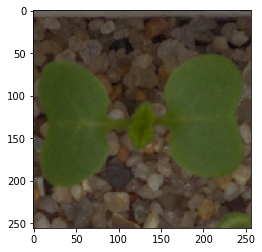

In [ ]:
plt.imshow(train_gen[0][0][image_no])

In [ ]:
from keras.models import Model
layer_before_flattening = 10 #Edit this with the layer you need the visualization for

viz_model = Model(inputs=model.inputs, outputs=model.layers[layer_before_flattening].output)
#viz_model.summary()

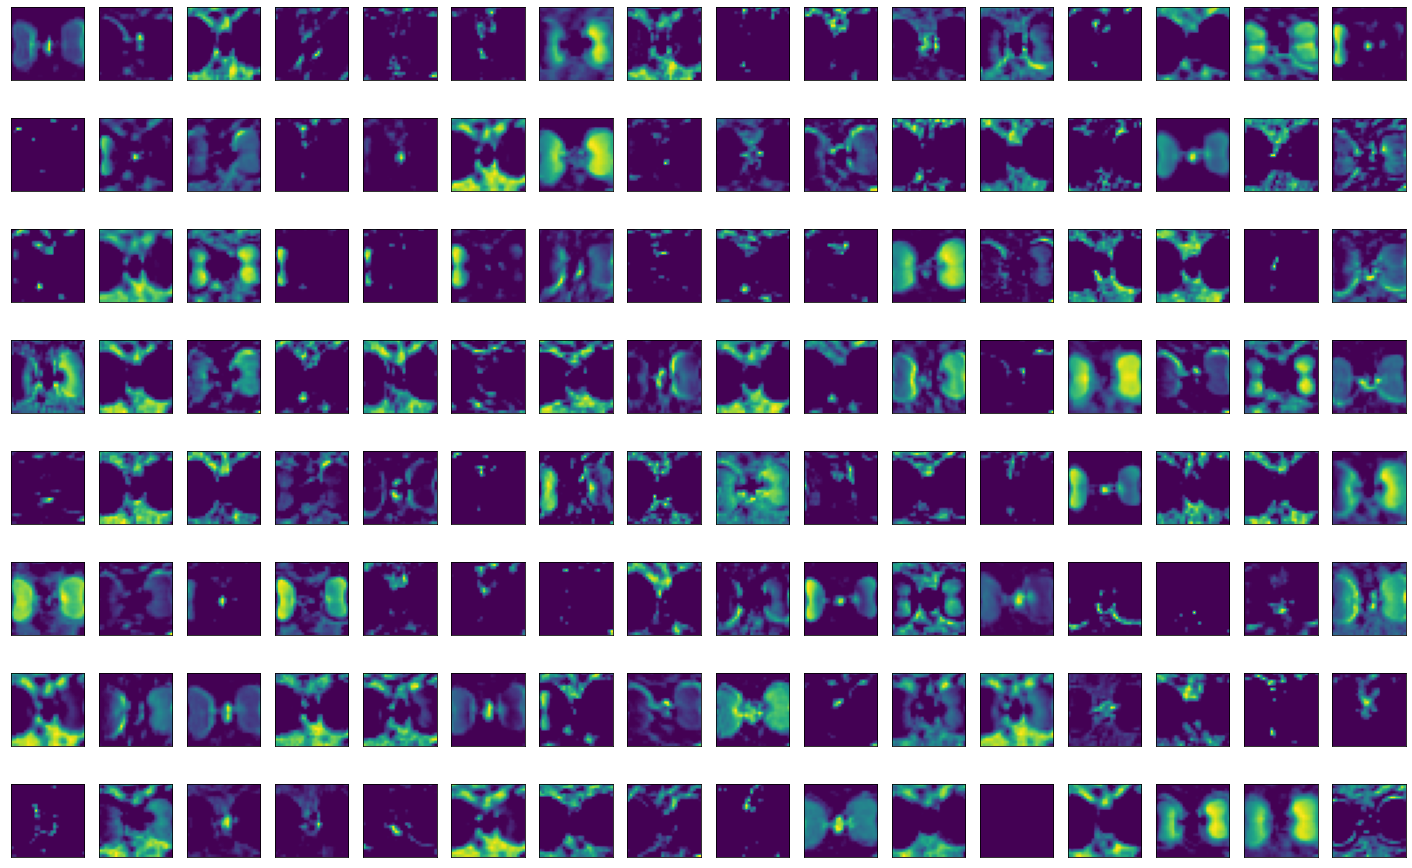

In [ ]:
nn = viz_model.predict(train_gen[0][0])
grid = (8, 16) 
ix = 1
fig = plt.figure(figsize=(25,16))
for _ in range(grid[0]):
    for _ in range(grid[1]):
        # specify subplot and turn of axis
        ax = fig.add_subplot(grid[0], grid[1], ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(nn[image_no, :, :, ix-1])
        ix += 1

plt.show()

In [ ]:
from tensorflow import keras
model = keras.models.load_model('imageclassModel.h5')

In [ ]:
predictions = model.predict(test_gen, steps=test_gen.samples)

In [ ]:
class_list=[]
for i in range(0, predictions.shape[0]):
  y_class = predictions[i, :].argmax(axis=-1)
  class_list += [list(classes.keys())[y_class]]

submission = pd.DataFrame()
submission['file'] = test_gen.filenames
submission['file'] = submission['file'].str.replace(r'test/', '')
submission['species'] = class_list


In [ ]:
submission.head(30)

,file,species
0,common_chickweed/1.png,mayweed
1,common_chickweed/10.png,silky_bent
2,common_chickweed/2.png,silky_bent
3,common_chickweed/3.png,silky_bent
4,common_chickweed/4.png,silky_bent
5,common_chickweed/5.png,mayweed
6,common_chickweed/6.png,mayweed
7,common_chickweed/7.png,common_chickweed
8,common_chickweed/8.png,silky_bent
9,common_chickweed/9.png,silky_bent


<b> Accuracy is not so good as our trained model has val accuracy only 70% <b>

##<b> Due to the hardware constraint,we shall reduce the training dataset by selecting  only 3 classes of species namely common chickweed, mayweed,silky bent and repeat the process
<b>

In [31]:
sclasses={ 
 'common_chickweed': 1,
 'mayweed': 2,
 'silky_bent': 3}

simage_size = 256
starget_size = (256, 256)
sbatch_size = 32

# create a data generator
sdatagen = ImageDataGenerator()
spath='/content/drive/My Drive/selectiveSpecies/'

<b> Loading the training dataset with 3 classes to dataframe <b>

In [ ]:
strain_df=pd.DataFrame(columns=['filename','class'])
for root,dir,filenames in os.walk(spath):
    for filename in filenames:
      path_name = os.path.join(root, filename)
      class_label = root.split('/')[-1]
      strain_df= strain_df.append({'filename':path_name , 'class':class_label}, ignore_index = True)

In [ ]:
sdf=sklearn.utils.shuffle(strain_df)
sdf.reset_index()
sdf.head(5)

,filename,class
1024,/content/drive/My Drive/selectiveSpecies/silky...,silky_bent
876,/content/drive/My Drive/selectiveSpecies/silky...,silky_bent
1641,/content/drive/My Drive/selectiveSpecies/maywe...,mayweed
1382,/content/drive/My Drive/selectiveSpecies/silky...,silky_bent
394,/content/drive/My Drive/selectiveSpecies/commo...,common_chickweed


<b> <b> Training the model with only 3 classes training dataset <b>

In [ ]:
def sget_model():
    model = tf.keras.models.Sequential() #1
    model.add(tf.keras.layers.InputLayer(input_shape=(image_size,image_size,3,))) #2
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')) #3
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')) #4
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #5
    model.add(tf.keras.layers.BatchNormalization()) #6
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu')) #7
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #8
    model.add(tf.keras.layers.BatchNormalization()) #9
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu')) #10
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #11
    model.add(tf.keras.layers.BatchNormalization()) #12
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu')) #13
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #14
    model.add(tf.keras.layers.GlobalMaxPool2D()) #15
    model.add(tf.keras.layers.Flatten()) #16 
    model.add(tf.keras.layers.Dense(128, activation='relu')) #17
    model.add(tf.keras.layers.Dropout(0.2)) #18
    model.add(tf.keras.layers.Dense(64, activation='relu')) #19
    model.add(tf.keras.layers.BatchNormalization()) #20
    model.add(tf.keras.layers.Dense(3, activation='softmax')) #21
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:

sidg = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            horizontal_flip=True,
            vertical_flip=True,
            validation_split=0.2
           )
strain_gen = sidg.flow_from_directory(spath,
                                    target_size=starget_size,
                                    subset='training',
                                    class_mode='categorical',
                                    batch_size=sbatch_size,
                                    shuffle=True,
                                    seed=1,
                                     classes=sclasses
                                     )
sval_gen = sidg.flow_from_directory(spath,
                                  target_size=(image_size, image_size),                                                   
                                  subset='validation',
                                  class_mode='categorical',
                                  batch_size=batch_size,
                                  shuffle=True,
                                  seed=1,
                                  classes=sclasses)

Found 1625 images belonging to 3 classes.
Found 405 images belonging to 3 classes.


In [ ]:
model = sget_model()

model_name = 'plant_classifier_fully_strained_'+str(rand_num)+'.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name, #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', min_delta=0.0001)
history = model.fit(strain_gen,
          epochs=15, # Increase number of epochs if you have sufficient hardware
          validation_data=sval_gen,
          callbacks = [checkpoint, es],
          verbose = 1)

Epoch 1/15
52/52 [==============================] - ETA: 0s - loss: 0.6489 - accuracy: 0.7258 
Epoch 1: val_accuracy improved from -inf to 0.36675, saving model to plant_classifier_fully_strained_9972.h5
52/52 [==============================] - 1017s 20s/step - loss: 0.6489 - accuracy: 0.7258 - val_loss: 1.5833 - val_accuracy: 0.3667
Epoch 2/15
52/52 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.9226 
Epoch 2: val_accuracy did not improve from 0.36675
52/52 [==============================] - 952s 18s/step - loss: 0.2296 - accuracy: 0.9226 - val_loss: 3.0147 - val_accuracy: 0.3667
Epoch 3/15
52/52 [==============================] - ETA: 0s - loss: 0.2027 - accuracy: 0.9317 
Epoch 3: val_accuracy did not improve from 0.36675
52/52 [==============================] - 954s 18s/step - loss: 0.2027 - accuracy: 0.9317 - val_loss: 3.7625 - val_accuracy: 0.3667
Epoch 4/15
52/52 [==============================] - ETA: 0s - loss: 0.1602 - accuracy: 0.9427 
Epoch 4: val_ac

<b> Model has 97% validation accuracy <b>

In [ ]:
from tensorflow import keras
model = keras.models.load_model('plant_classifier_fully_strained_9972.h5')

In [25]:
from tensorflow import keras
model = keras.models.load_model('plant_classifier_fully_strained_9972.h5')

In [28]:
idg5 = tf.keras.preprocessing.image.ImageDataGenerator(
                        rescale=1./255,
                        horizontal_flip=True,
                        vertical_flip=True
                       )
test_gen = idg5.flow_from_directory(path_test,
                                    target_size=(image_size, image_size),
                                    class_mode='categorical',
                                    #batch_size=batch_size,
                                    shuffle=True,
                                    seed=1
                                                        )

Found 50 images belonging to 1 classes.


In [29]:
predictions = model.predict(test_gen, steps=test_gen.samples)

In [32]:
class_list=[]
for i in range(0, predictions.shape[0]):
  y_class = predictions[i, :].argmax(axis=-1)
  class_list += [list(sclasses.keys())[y_class]]


In [33]:
sub = pd.DataFrame()
sub['file'] = test_gen.filenames
sub['file'] = sub['file'].str.replace(r'test/', '')
sub['species'] = class_list

In [34]:
sub['actual_Name']=sub.apply(lambda row:row['file'].split(sep='/')[0],axis=1 )

In [35]:
def convert_string(sample):
  if sample == "common_chickweed":
     return 0
  if sample == "mayweed":
     return 1  
  if sample == "silky_bent":
     return 2     

sub['convert']=sub['actual_Name'].apply(lambda x: convert_string(x))
yhat=sub['convert'].to_list()
ypred = predictions.argmax(axis=-1)

In [37]:
from sklearn.metrics import accuracy_score
result=accuracy_score(yhat, ypred)
print("Testing accuracy with base model :",result*100,"%")

Testing accuracy with base model : 78.0 %


In [ ]:
sub[['actual_Name','species']]

,actual_Name,species
0,common_chickweed,mayweed
1,common_chickweed,common_chickweed
2,common_chickweed,common_chickweed
3,common_chickweed,common_chickweed
4,common_chickweed,mayweed
5,common_chickweed,common_chickweed
6,common_chickweed,common_chickweed
7,common_chickweed,mayweed
8,common_chickweed,mayweed
9,common_chickweed,common_chickweed


##<b>3 Fold Cross validation with the dataset of only 3 classes <b>

In [ ]:
kfold = KFold(n_splits=3, shuffle=True)
fold = 1
accuracies = []
rand_num = randrange(20)

In [ ]:
for train, test in kfold.split(sdf):
    model = sget_model()
    idg = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            horizontal_flip=True,
            vertical_flip=True,
            validation_split=0.2
           )
    #Actual Training data for the model
    strain_gen = sidg.flow_from_directory(spath,
                                    target_size=target_size,
                                    subset='training',
                                    class_mode='categorical',
                                    batch_size=batch_size,
                                    shuffle=True,
                                    seed=1,
                                     classes=sclasses
                                     )
    sval_gen = sidg.flow_from_directory(spath,
                                      target_size=(image_size, image_size),                                                   
                                      subset='validation',
                                      class_mode='categorical',
                                      batch_size=batch_size,
                                      shuffle=True,
                                      seed=1,
                                      classes=sclasses)
    

    model_name = 'crossval_plant_classifier_'+str(rand_num)+'_fold_no_'+str(fold)+'.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1
                                                    )
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', min_delta=0.0001)
    history = model.fit(strain_gen,
                        epochs=15,
                        validation_data=sval_gen,
                        callbacks = [checkpoint, es],
                        verbose = 1
                        )
    # Testing the fold
    idg2 = tf.keras.preprocessing.image.ImageDataGenerator(
                        rescale=1./255,
                        horizontal_flip=True,
                        vertical_flip=True
                       )
    test_gen = idg5.flow_from_directory(path_test,
                                    target_size=(image_size, image_size),
                                    class_mode='categorical',
                                    #batch_size=batch_size,
                                    shuffle=True,
                                    seed=1)

    model.load_weights('./'+model_name)
    predictions = model.predict(test_gen, steps=test_gen.samples)
    y_pred = []
    for i in range(0, predictions.shape[0]):
      y_class = predictions[i, :].argmax(axis=-1)
      y_pred.append(y_class)
    accuracies.append(accuracy_score(test_gen.classes, y_pred))
    print("________________________________________________________")
    print('Test Accuracy for the fold ',fold, ': ', accuracies[fold-1])
    fold += 1

Found 1641 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Epoch 1/15
52/52 [==============================] - ETA: 0s - loss: 0.5391 - accuracy: 0.7831 
Epoch 1: val_accuracy improved from -inf to 0.36675, saving model to crossval_plant_classifier_3_fold_no_1.h5
52/52 [==============================] - 910s 17s/step - loss: 0.5391 - accuracy: 0.7831 - val_loss: 2.1470 - val_accuracy: 0.3667
Epoch 2/15
52/52 [==============================] - ETA: 0s - loss: 0.2345 - accuracy: 0.9202 
Epoch 2: val_accuracy did not improve from 0.36675
52/52 [==============================] - 903s 17s/step - loss: 0.2345 - accuracy: 0.9202 - val_loss: 3.3624 - val_accuracy: 0.3667
Epoch 3/15
52/52 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9269 
Epoch 3: val_accuracy did not improve from 0.36675
52/52 [==============================] - 900s 17s/step - loss: 0.2151 - accuracy: 0.9269 - val_loss: 3.1084 - val_accuracy: 0.3667
Epoch 4/15
52/52 [=========

 <b> Observation <b> 
 * 3 Folds cross validation completed successfully.
 * Training accuracy: 0.9452 
 * val_loss: 0.1744  
 * val_accuracy: 0.9438

In [ ]:
from tensorflow import keras
model = keras.models.load_model('crossval_plant_classifier_3_fold_no_1.h5')

In [ ]:
predictions = model.predict(test_gen, steps=test_gen.samples)

In [ ]:
class_list=[]
for i in range(0, predictions.shape[0]):
  y_class = predictions[i, :].argmax(axis=-1)
  class_list += [list(sclasses.keys())[y_class]]
sub = pd.DataFrame()
sub['file'] = test_gen.filenames
sub['file'] = sub['file'].str.replace(r'test/', '')
sub['species'] = class_list  
sub['actual_Name']=sub.apply(lambda row:row['file'].split(sep='/')[0],axis=1 )
sub['convert']=sub['actual_Name'].apply(lambda x: convert_string(x))
yhat=sub['convert'].to_list()
ypred = predictions.argmax(axis=-1)
from sklearn.metrics import accuracy_score
result=accuracy_score(yhat, ypred)
print("Test Accuracy after cross validation : ",result*100,'%' )


Accuracy after cross validation :  98.0 %


In [ ]:
sub[['actual_Name','species']]

,actual_Name,species
0,common_chickweed,common_chickweed
1,common_chickweed,common_chickweed
2,common_chickweed,common_chickweed
3,common_chickweed,common_chickweed
4,common_chickweed,common_chickweed
5,common_chickweed,common_chickweed
6,common_chickweed,common_chickweed
7,common_chickweed,common_chickweed
8,common_chickweed,common_chickweed
9,common_chickweed,common_chickweed


## <b> Conclusion <b>

* After 3 fold  cross validation the testing accuracy has improved to 98% <b>

<b> Visualizing test image on 10th layer of final model <b>

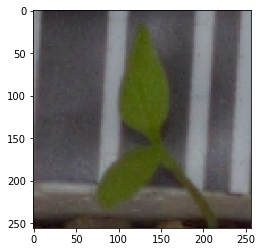

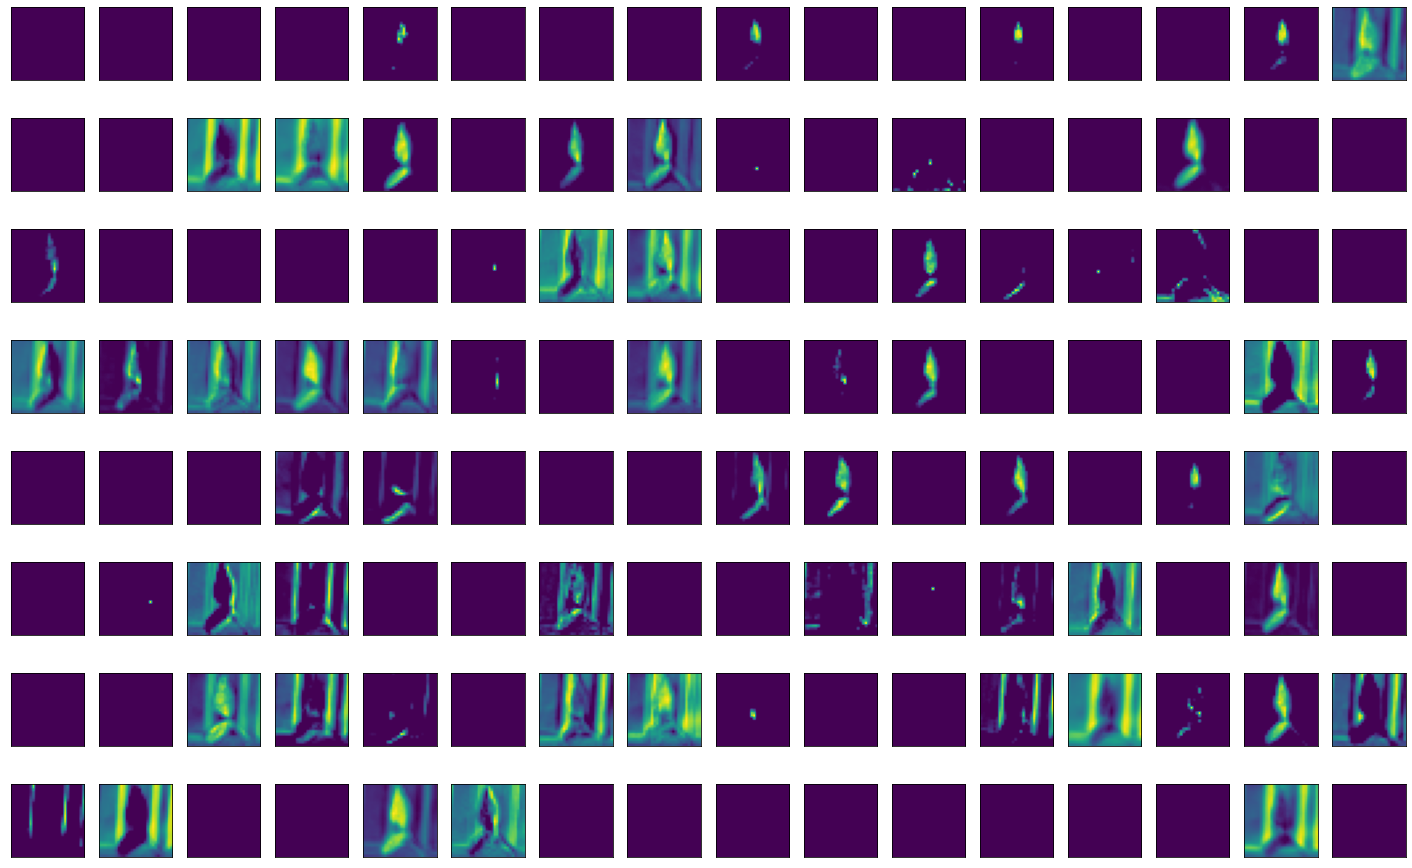

In [ ]:
testimage_no=22
plt.imshow((test_it[0][0][testimage_no]).astype('uint8'))
from keras.models import Model
layer_before_flattening = 10 #Edit this with the layer you need the visualization for

viz_model = Model(inputs=model.inputs, outputs=model.layers[layer_before_flattening].output)
#viz_model.summary()

nn = viz_model.predict(test_it[0][0])
grid = (8, 16) 
ix = 1
fig = plt.figure(figsize=(25,16))
for _ in range(grid[0]):
    for _ in range(grid[1]):
        # specify subplot and turn of axis
        ax = fig.add_subplot(grid[0], grid[1], ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(nn[testimage_no, :, :, ix-1])
        ix += 1

plt.show()